## **Preparing Data**

In [1]:
!apt install python3.7
!pip install -U torchtext==0.6.0
!pip install einops
!python -m spacy download en
!python -m spacy download de

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libpython3.7-minimal libpython3.7-stdlib mailcap mime-support python3.7-minimal
Suggested packages:
  python3.7-venv binfmt-support
The following NEW packages will be installed:
  libpython3.7-minimal libpython3.7-stdlib mailcap mime-support python3.7 python3.7-minimal
0 upgraded, 6 newly installed, 0 to remove and 19 not upgraded.
Need to get 4,698 kB of archives.
After this operation, 17.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 mailcap all 3.70+nmu1ubuntu1 [23.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 mime-support all 3.66 [3,696 B]
Get:3 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy/main amd64 libpython3.7-minimal amd64 3.7.17-1+jammy1 [608 kB]
Get:4 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy/main amd64 python3.7-minimal am

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import spacy
import numpy as np
from einops import rearrange, repeat

import random
import math
import time

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
!git clone https://github.com/neychev/small_DL_repo.git

Cloning into 'small_DL_repo'...
remote: Enumerating objects: 297, done.
remote: Counting objects: 100% (216/216), done.
remote: Compressing objects: 100% (181/181), done.
remote: Total 297 (delta 67), reused 155 (delta 28), pack-reused 81
Receiving objects: 100% (297/297), 25.15 MiB | 26.74 MiB/s, done.
Resolving deltas: 100% (89/89), done.


In [4]:
!mkdir ./data
!mkdir ./data/multi30k
!tar -zxvf ./small_DL_repo/datasets/Multi30k/training.tar.gz -C ./data/multi30k
!tar -zxvf ./small_DL_repo/datasets/Multi30k/validation.tar.gz -C ./data/multi30k
!tar -zxvf ./small_DL_repo/datasets/Multi30k/mmt_task1_test2016.tar.gz -C ./data/multi30k

train.de
train.en
val.de
val.en
test2016.fr
test2016.en
test2016.de


### **Tokenizers**
- We convert sentences to individual tokens by using tokenizers.
  - e.g. "good morning!" becomes ["good", "morning", "!"]
- We will use python package `spaCy` for this

In [5]:
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

In [6]:
def tokenize_de(text):
  return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
  return [tok.text for tok in spacy_en.tokenizer(text)]

We use Field library to process data. By setting batch_first = True, we set the batch dimension comes first.

In [7]:
SRC = Field(tokenize= tokenize_de,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True,
            batch_first = True)

TRG = Field(tokenize= tokenize_en,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True,
            batch_first = True)

We use Multi30k dataset of about 30k English, Deutch, and French sentences, and each sentence has 12 words. We set exts as the langauges for source and target languages.

In [8]:
train_data, valid_data, test_data = Multi30k.splits(exts= ('.de', '.en'),
                                                    fields = (SRC, TRG),
                                                    root='./data/')

In [9]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


In [10]:
print(len(vars(train_data.examples[0])['src']))
print(len(vars(train_data.examples[1])['src']))

print(vars(train_data.examples[0]))
print(vars(train_data.examples[1]))

13
8
{'src': ['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.'], 'trg': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}
{'src': ['mehrere', 'männer', 'mit', 'schutzhelmen', 'bedienen', 'ein', 'antriebsradsystem', '.'], 'trg': ['several', 'men', 'in', 'hard', 'hats', 'are', 'operating', 'a', 'giant', 'pulley', 'system', '.']}


## **Build Vocabulary**
- We use `build_vocab` function to get indexing of tokens. Note that the vocabularies of source and target are different.
- We use `min_freq` to have words that appear at least twice in the corpus to add to the vocabulary. So the word that apears only once will convert to <unk> token.
- Note that we have to use only training set to build the vocabulary, neither validation nor test set.

In [11]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [12]:
print(f"Unique tokens in source (de) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (de) vocabulary: 7853
Unique tokens in target (en) vocabulary: 5893


### Create the iterators
- we use `BucketIterator` to pack tokens as a batch and convert tokens to indices.

In [13]:
# for using GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device
)

## **Building the Model**

### Encoder
 - For positional encoding, we use postional embedding as in BERT unlike the positional encoding in the original Transformer paper.

In [15]:
class Encoder(nn.Module):
    def __init__(self,
                 input_dim,
                 hid_dim,
                 n_layers,
                 n_heads,
                 pf_dim,
                 dropout,
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device

        ''' Input Embedding '''
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)

        ''' Multiple Encoder Layers '''
        # we use multiple encoder layers (e.g., 6 in the original Transformer paper)
        self.layers = nn.ModuleList([EncoderLayer(hid_dim,
                                                  n_heads,
                                                  pf_dim,
                                                  dropout,
                                                  device)
                                     for _ in range(n_layers)])

        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, src, src_mask):

        ## TODO: write down the forward step

        b, src_n = src.shape
        pos = repeat(torch.arange(0, src_n), "n -> b n", b=b).to(self.device) # (b, src_n)
        output = self.dropout((self.tok_embedding(src)*self.scale) + self.pos_embedding(pos)) # (b, src_n, h)
        hidden = output
        for layer in self.layers:
            output = layer(output, src_mask)
        return output, hidden

### Encoder layer

In [16]:
class EncoderLayer(nn.Module):
    def __init__(self,
                 hid_dim,
                 n_heads,
                 pf_dim,
                 dropout,
                 device):
        super().__init__()

        ''' Multi Head self-Attention '''
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)

        ''' Positional FeedForward Layer'''
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim,
                                                                     pf_dim,
                                                                     dropout)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask):

        # TODO: write your code

        src_, _ = self.self_attention(src, src, src, src_mask)
        src = self.self_attn_layer_norm(src + self.dropout(src_)) # (b, src_n, h)

        src_ = self.positionwise_feedforward(src)
        src = self.ff_layer_norm(src + self.dropout(src_)) # (b, src_n, b)
        return src

### Multi Head Attention Layer

In [17]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()

        # TODO: write your code

        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads

        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

        self.to_q = nn.Linear(hid_dim, hid_dim)
        self.to_k = nn.Linear(hid_dim, hid_dim)
        self.to_v = nn.Linear(hid_dim, hid_dim)
        self.to_out = nn.Linear(hid_dim, hid_dim)

        self.dropout = nn.Dropout(dropout)


    def forward(self, query, key, value, mask = None):

        # TODO: write your code

        assert self.hid_dim % self.n_heads == 0

        q = self.to_q(query) # (b, n_q, c) -> c: hid_dim (n_heads * head_dim)
        k = self.to_k(key) # (b, n_k, c)
        v = self.to_v(value) # (b, n_v, c), n_k = n_v

        q, k, v = map(lambda t: rearrange(t, "b n (m d) -> b m n d", m=self.n_heads, d=self.head_dim), (q, k, v))
        # q: (b, m, n_q, d), k: (b, m, n_k, d), v: (b, m, v_k, d)

        e = torch.einsum("b m i d, b m j d -> b m i j", q, k) / self.scale # (b, m, n_q, n_k)

        if mask is not None:
            e = e.masked_fill(mask==0, -torch.finfo(e.dtype).max)

        attention = torch.softmax(e, dim=-1) # (b, m, n_q, n_k)
        x = torch.einsum("b m i j, b m j d -> b m i d", self.dropout(attention), v) # (b, m, n_q, d)
        x = rearrange(x, "b m n d -> b n (m d)").contiguous() # (b, n_q, c)
        x = self.to_out(x) # (b, n_q, c)
        return x, attention

### Position-wise Feedforward Layer

In [18]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()

        # TODO: write your code

        self.net = nn.Sequential(
            nn.Linear(hid_dim, pf_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(pf_dim, hid_dim)
        )

    def forward(self, x):

        # TODO: write your code

        x = self.net(x)

        return x

### Decoder

In [19]:
class Decoder(nn.Module):
    def __init__(self,
                 output_dim,
                 hid_dim,
                 n_layers,
                 n_heads,
                 pf_dim,
                 dropout,
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(output_dim, hid_dim)

        self.pos_embedding = nn.Embedding(max_length, hid_dim)

        self.layers = nn.ModuleList([DecoderLayer(hid_dim,
                                                  n_heads,
                                                  pf_dim,
                                                  dropout,
                                                  device)
                                     for _ in range(n_layers)])

        self.fc_out = nn.Linear(hid_dim, output_dim)

        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)



    def forward(self, trg, enc_src, trg_mask, src_mask):

        # TODO: write your code

        b, trg_n = trg.shape
        pos = repeat(torch.arange(0, trg_n), "n -> b n", b=b).to(self.device) # (b, trg_n)
        trg = self.dropout((self.tok_embedding(trg)*self.scale) + self.pos_embedding(pos)) # (b, trg_n, h)
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask) # (b, trg_n, h), (b, m, trg_n, src_n)

        output = self.fc_out(trg) # (b, trg_n, out_dim)
        return output, attention


### Decoder Layer

In [20]:
class DecoderLayer(nn.Module):
    def __init__(self,
                 hid_dim,
                 n_heads,
                 pf_dim,
                 dropout,
                 device):
        super().__init__()

        ''' Multi Head self Attention'''
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)

        ''' Encoder-decoder attention'''
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)

        ''' Positionwise FeedForward Layer'''
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim,
                                                                     pf_dim,
                                                                     dropout)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        # TODO: write your code

        trg_, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg = self.self_attn_layer_norm(trg + self.dropout(trg_))

        trg_, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg = self.enc_attn_layer_norm(trg + self.dropout(trg_))

        trg_ = self.positionwise_feedforward(trg)
        trg = self.ff_layer_norm(trg + self.dropout(trg_)) # (b, trg_n, h)

        return trg, attention

### Sequence-to-sequence model

In [21]:
class Seq2Seq(nn.Module):
    def __init__(self,
                 encoder,
                 decoder,
                 src_pad_idx,
                 trg_pad_idx,
                 device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device


    def forward(self, src, trg):

        ## TODO: write down the forward step

        src_mask = rearrange((src!=self.src_pad_idx), "b n -> b 1 1 n")

        trg_n = trg.shape[1]
        trg_pad_mask = rearrange((trg!=self.trg_pad_idx), "b n -> b 1 1 n")
        trg_sub_mask = torch.tril(torch.ones((trg_n, trg_n), device=self.device)).bool() # (trg_n, trg_n)
        trg_mask = trg_pad_mask & trg_sub_mask # (b, 1, trg_n, trg_n)

        enc_src, _ = self.encoder(src, src_mask) # (b, src_n, h)
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask) # (b, trg_n, out_dim), (b, m, trg_n, src_n)

        return output, attention

### Training the Seq2Seq Model

In [22]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1


enc = Encoder(INPUT_DIM,
              HID_DIM,
              ENC_LAYERS,
              ENC_HEADS,
              ENC_PF_DIM,
              ENC_DROPOUT,
              device)

dec = Decoder(OUTPUT_DIM,
              HID_DIM,
              DEC_LAYERS,
              DEC_HEADS,
              DEC_PF_DIM,
              DEC_DROPOUT,
              device)

In [23]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [24]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,038,341 trainable parameters


We initialize model weights

In [25]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights);

We use Adam as our optimizer and CrossEntropyLoss. Also we set to ignore <pad> token in calculating loss

In [26]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [27]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

### Training

In [28]:
def train(model, iterator, optimizer, criterion):

    model.train()

    epoch_loss = 0

    for i, batch in enumerate(iterator):

        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()

        # TODO: write down your training code here

        output, attention = model(src, trg[:, :-1]) # (b, trg_n-1, out_dim)

        output_dim = output.shape[-1]

        output = rearrange(output, "b n d -> (b n) d").contiguous()
        trg = rearrange(trg[:, 1:], "b n -> (b n)").contiguous() # (b, trg_n-1)

        loss = criterion(output, trg)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

### Evaluation

In [29]:
def evaluate(model, iterator, criterion):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            # TODO: write down your training code here

            output, attention = model(src, trg[:, :-1]) # (b, trg_n-1, out_dim)

            output_dim = output.shape[-1]

            output = rearrange(output, "b n d -> (b n) d").contiguous()
            trg = rearrange(trg[:, 1:], "b n -> (b n)").contiguous() # (b, trg_n-1)

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [30]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Train the model through multiple epochs

In [31]:
N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_iterator, optimizer, criterion)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'my-model-2-a.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Time: 0m 16s
	Train Loss: 4.273
	 Val. Loss: 3.010
Epoch: 02 | Time: 0m 13s
	Train Loss: 2.769
	 Val. Loss: 2.247
Epoch: 03 | Time: 0m 13s
	Train Loss: 2.168
	 Val. Loss: 1.936
Epoch: 04 | Time: 0m 13s
	Train Loss: 1.812
	 Val. Loss: 1.769
Epoch: 05 | Time: 0m 14s
	Train Loss: 1.567
	 Val. Loss: 1.656
Epoch: 06 | Time: 0m 14s
	Train Loss: 1.378
	 Val. Loss: 1.624
Epoch: 07 | Time: 0m 14s
	Train Loss: 1.229
	 Val. Loss: 1.592
Epoch: 08 | Time: 0m 14s
	Train Loss: 1.101
	 Val. Loss: 1.601
Epoch: 09 | Time: 0m 14s
	Train Loss: 0.997
	 Val. Loss: 1.616
Epoch: 10 | Time: 0m 14s
	Train Loss: 0.902
	 Val. Loss: 1.629


In [32]:
model.load_state_dict(torch.load('my-model-2-a.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f}')

| Test Loss: 1.659


### Inference and attention visualization

In [33]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [34]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()

    # TODO: write your code

    tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    src_indices = [src_field.vocab.stoi[token] for token in tokens]
    src_tensor = rearrange(torch.LongTensor(src_indices), "i -> 1 i").to(device)

    src_mask = rearrange((src_tensor!=model.src_pad_idx), "b n -> b 1 1 n")

    with torch.no_grad():
        enc_output, _ = model.encoder(src_tensor, src_mask)

    trg_indices = [trg_field.vocab.stoi[trg_field.init_token]]
    for i in range(max_len):
        trg_tensor = rearrange(torch.LongTensor(trg_indices), "i -> 1 i").to(device)

        trg_pad_mask = rearrange((trg_tensor!=model.trg_pad_idx), "b n -> b 1 1 n")
        trg_len = trg_tensor.shape[1]
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device=model.device)).bool() # (trg_n, trg_n)
        trg_mask = trg_pad_mask & trg_sub_mask # (b, 1, trg_n, trg_n)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_output, trg_mask, src_mask)

        pred_token = output.argmax(2)[:, -1].item()
        trg_indices.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break

    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indices]
    decoded_words = trg_tokens[1:]
    decoder_attentions = attention

    return decoded_words, decoder_attentions

In [35]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):

    assert n_rows * n_cols == n_heads

    # Set up figure with colorbar
    fig = plt.figure(figsize=(15,25))

    for i in range(n_heads):

        ax = fig.add_subplot(n_rows, n_cols, i+1)

        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        # Set up axes
        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        # Show label at every tick
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()


In [36]:
example_idx = 6

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'brauner', 'hund', 'rennt', 'dem', 'schwarzen', 'hund', 'hinterher', '.']
trg = ['a', 'brown', 'dog', 'is', 'running', 'after', 'the', 'black', 'dog', '.']


In [37]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'brown', 'dog', 'runs', 'after', 'the', 'black', 'dog', '.', '<eos>']


<ipython-input-35-8d671d786945>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
<ipython-input-35-8d671d786945>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


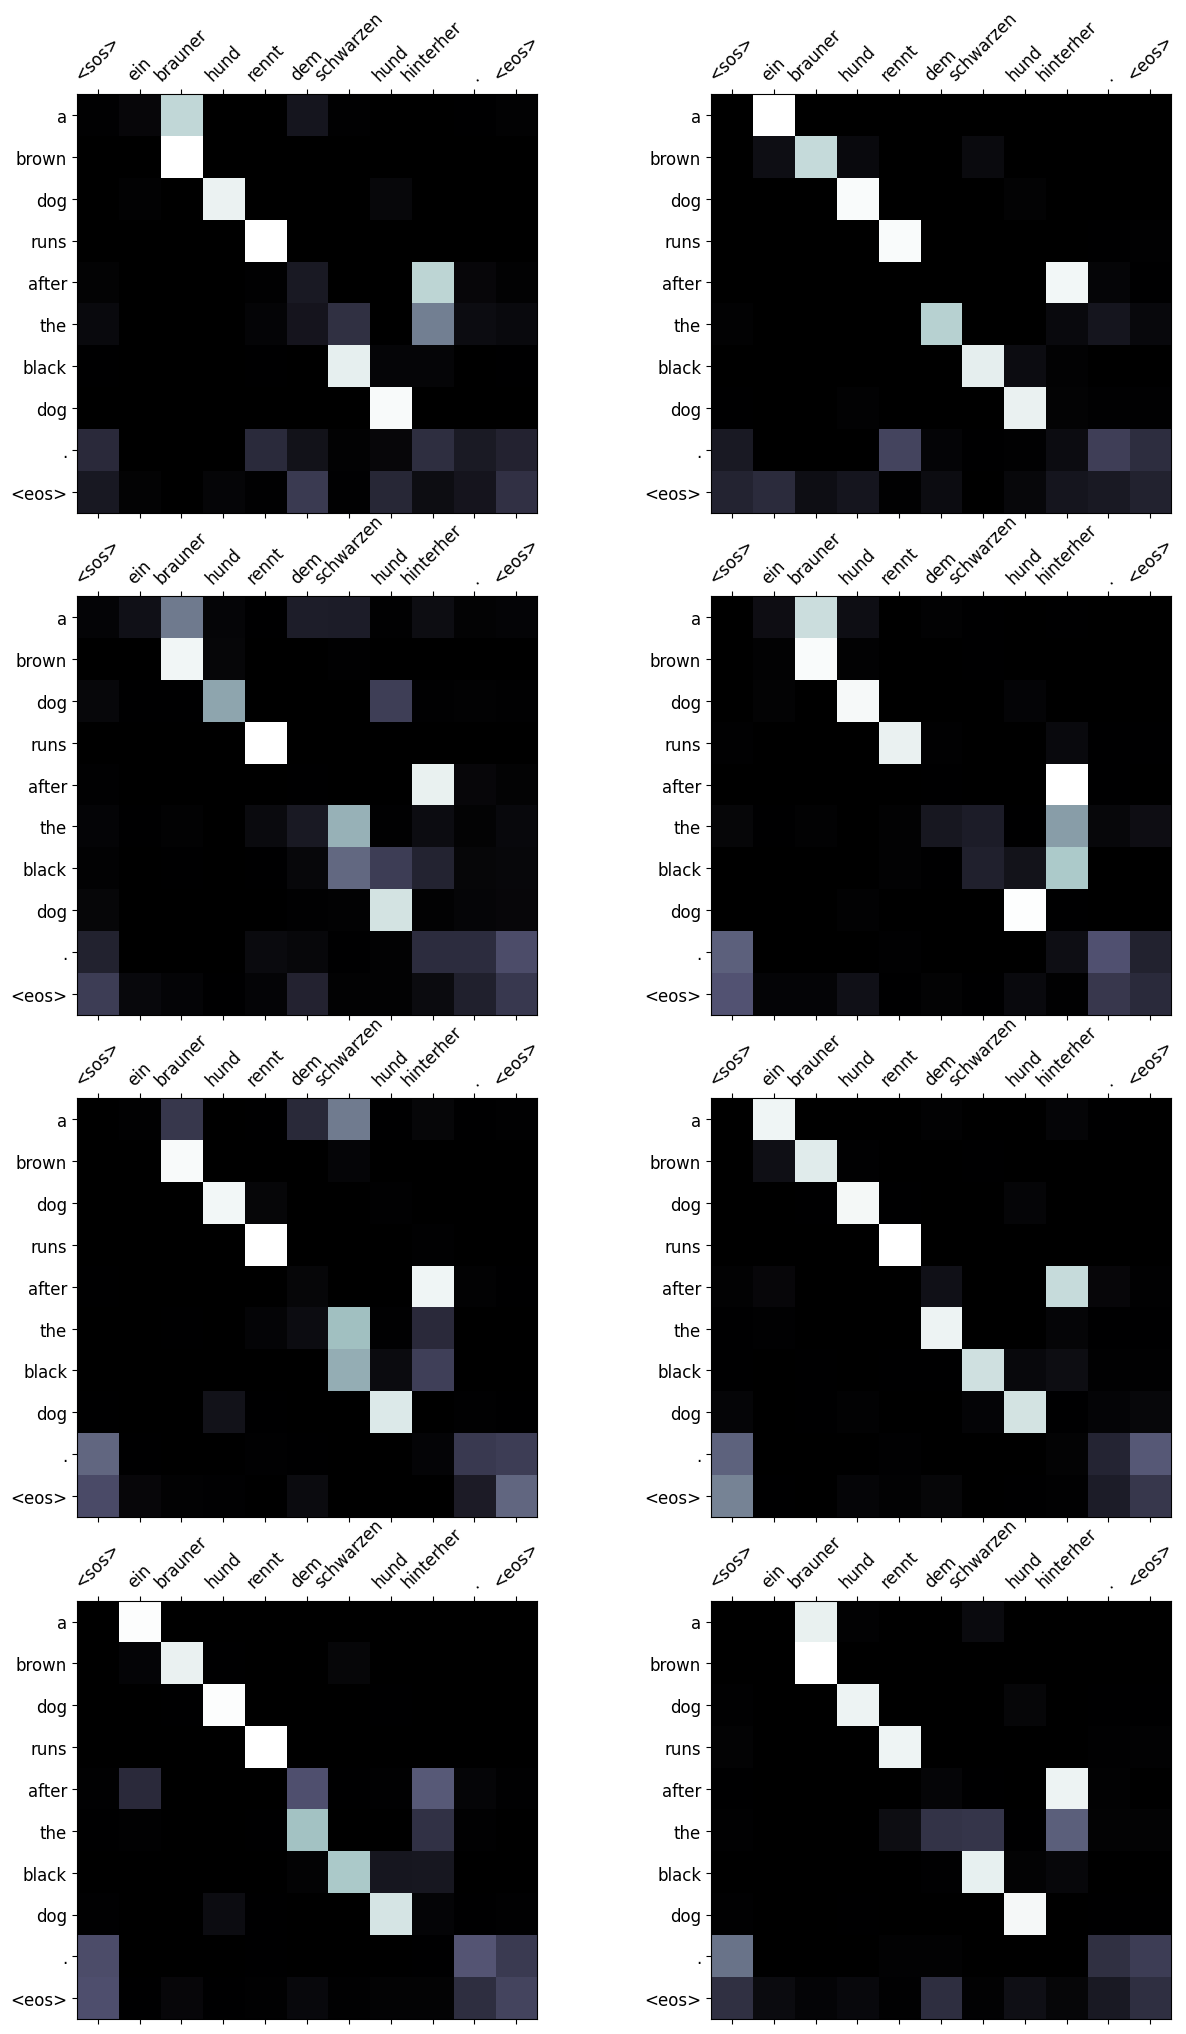

In [38]:
display_attention(src, translation, attention)

### BLEU
- Calculate BLEU for test set

In [39]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):

    trgs = []
    pred_trgs = []

    for datum in data:

        src = vars(datum)['src']
        trg = vars(datum)['trg']

        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)

        #cut off <eos> token
        pred_trg = pred_trg[:-1]

        pred_trgs.append(pred_trg)
        trgs.append([trg])

    return bleu_score(pred_trgs, trgs)

In [40]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 35.65


# Tune the model

In [41]:
!pip install transformers
!pip install packaging==21.3
!pip install torchmetrics==0.6

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 74.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 1.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 23.2
    Uninstalling packaging-23.2:
      Successfully uninstalled packaging-23.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.4/329.4 kB 6.7 MB/s eta 0:00:00


In [42]:
from transformers import BertTokenizerFast

In [43]:
class BERTTokenizer(nn.Module):
    """ Uses a pretrained BERT tokenizer by huggingface. Vocab size: 30522"""
    def __init__(self, device="cuda", max_length=77, language="en"):
        super().__init__()
        assert language in ["en", "de"]

        if language == "en":
            self.tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
        else:
            self.tokenizer = BertTokenizerFast.from_pretrained("bert-base-german-dbmdz-uncased")
        self.device = device
        self.max_length = max_length

    def forward(self, text):
        batch_encoding = self.tokenizer(text, truncation=True, max_length=self.max_length, return_length=True,
                                        return_overflowing_tokens=False, padding="max_length", return_tensors="pt")
        tokens = batch_encoding["input_ids"].to(self.device)
        return tokens

In [44]:
def tokenize_de(text):
    return [tok for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    return [tok for tok in spacy_en.tokenizer(text)]

In [45]:
bert_tokenizer_de = BertTokenizerFast.from_pretrained("bert-base-uncased")
bert_de_vocab_size = len(bert_tokenizer_de)
bert_tokenizer_en = BertTokenizerFast.from_pretrained("bert-base-german-dbmdz-uncased")
bert_en_vocab_size = len(bert_tokenizer_en)

print("vocab_size of German BertTokenizer: ", bert_de_vocab_size)
print("vocab_size of English BertTokenizer: ", bert_en_vocab_size)

vocab_size of German BertTokenizer:  30522
vocab_size of English BertTokenizer:  31102


In [46]:
def bert_tokenize_de(text):
    return [bert_tokenizer_de.decode(tok) for tok in bert_tokenizer_de(text, add_special_tokens=False)["input_ids"]]

def bert_tokenize_en(text):
    return [bert_tokenizer_en.decode(tok) for tok in bert_tokenizer_en(text, add_special_tokens=False)["input_ids"]]

In [47]:
text = "Hi. I'm Sangjune Park. I am confidence. Nice to meet you."

In [48]:
tokenize_de(text)

[Hi, ., I'm, Sangjune, Park, ., I, am, confidence, ., Nice, to, meet, you, .]

In [49]:
tokenize_en(text)

[Hi, ., I, 'm, Sangjune, Park, ., I, am, confidence, ., Nice, to, meet, you, .]

In [50]:
bert_tokenizer_en = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [51]:
bert_tokenize_de(text)

['hi',
 '.',
 'i',
 "'",
 'm',
 'sang',
 '##jun',
 '##e',
 'park',
 '.',
 'i',
 'am',
 'confidence',
 '.',
 'nice',
 'to',
 'meet',
 'you',
 '.']

We use Field library to process data. By setting batch_first = True, we set the batch dimension comes first.

In [52]:
BSRC = Field(tokenize= bert_tokenize_de,
             init_token = '[CLS]',
             eos_token = '[SEP]',
             lower = True,
             batch_first = True)

BTRG = Field(tokenize= bert_tokenize_en,
             init_token = '[CLS]',
             eos_token = '[SEP]',
             lower = True,
             batch_first = True)

We use Multi30k dataset of about 30k English, Deutch, and French sentences, and each sentence has 12 words. We set exts as the langauges for source and target languages.

In [53]:
train_data_b, valid_data_b, test_data_b = Multi30k.splits(exts= ('.de', '.en'),
                                                          fields = (BSRC, BTRG),
                                                          root='./data/')

In [54]:
print(f"Number of training examples: {len(train_data_b.examples)}")
print(f"Number of validation examples: {len(valid_data_b.examples)}")
print(f"Number of testing examples: {len(test_data_b.examples)}")

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


In [55]:
print(len(vars(train_data_b.examples[0])['src']))
print(len(vars(train_data_b.examples[1])['src']))

print(vars(train_data_b.examples[0]))
print(vars(train_data_b.examples[1]))

22
22
{'src': ['z', '##wei', 'jung', '##e', 'wei', '##ße', 'manner', 'sin', '##d', 'im', 'fr', '##ei', '##en', 'in', 'der', 'nah', '##e', 'vie', '##ler', 'busch', '##e', '.'], 'trg': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}
{'src': ['me', '##hrer', '##e', 'manner', 'mit', 'sc', '##hu', '##tz', '##helm', '##en', 'bed', '##ien', '##en', 'ein', 'ant', '##rie', '##bs', '##rad', '##sy', '##ste', '##m', '.'], 'trg': ['several', 'men', 'in', 'hard', 'hats', 'are', 'operating', 'a', 'giant', 'pull', '##ey', 'system', '.']}


## **Build Vocabulary**
- We use `build_vocab` function to get indexing of tokens. Note that the vocabularies of source and target are different.
- We use `min_freq` to have words that appear at least twice in the corpus to add to the vocabulary. So the word that apears only once will convert to <unk> token.
- Note that we have to use only training set to build the vocabulary, neither validation nor test set.

In [56]:
from collections import defaultdict, Counter
from torchtext.vocab import Vocab

In [57]:
def build_bert_vocab(tokenizer, bert_vocab, field):
    vocab_stoi = defaultdict(lambda: tokenizer.unk_token_id)
    vocab_stoi.update({tok: idx for tok, idx in bert_vocab.items()})
    vocab_itos = [None] * len(vocab_stoi)
    for tok, idx in vocab_stoi.items():
        vocab_itos[idx] = tok

    vocab_counter = Counter({tok: 1 for tok in bert_vocab.keys()})

    field.vocab = Vocab(counter=vocab_counter, max_size=None, min_freq=2, specials=["[UNK]", "[PAD]", "[CLS]", "[SEP]"])
    field.vocab.stoi = vocab_stoi
    field.vocab.itos = vocab_itos
    field.vocab.vectors = None

    return field

In [58]:
BSRC = build_bert_vocab(bert_tokenizer_de, bert_tokenizer_de.get_vocab(), BSRC)
BTRG = build_bert_vocab(bert_tokenizer_en, bert_tokenizer_en.get_vocab(), BTRG)

In [59]:
print(f"Unique tokens in source (de) vocabulary: {len(BSRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(BTRG.vocab)}")

Unique tokens in source (de) vocabulary: 30522
Unique tokens in target (en) vocabulary: 30522


### Create the iterators
- we use `BucketIterator` to pack tokens as a batch and convert tokens to indices.

In [60]:
# for using GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [61]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data_b, valid_data_b, test_data_b),
    batch_size = BATCH_SIZE,
    device = device
)

## Building the Model with BERT Tokenizer and Embedding

### Encoder
 - For positional encoding, we use postional embedding as in BERT unlike the positional encoding in the original Transformer paper.

In [62]:
class Encoder(nn.Module):
    def __init__(self,
                 input_dim,
                 hid_dim,
                 n_layers,
                 n_heads,
                 pf_dim,
                 dropout,
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device

        ''' Input Embedding '''
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)

        ''' Multiple Encoder Layers '''
        # we use multiple encoder layers (e.g., 6 in the original Transformer paper)
        self.layers = nn.ModuleList([EncoderLayer(hid_dim,
                                                  n_heads,
                                                  pf_dim,
                                                  dropout,
                                                  device)
                                     for _ in range(n_layers)])

        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, src, src_mask):

        ## TODO: write down the forward step

        b, src_n = src.shape
        pos = repeat(torch.arange(0, src_n), "n -> b n", b=b).to(self.device) # (b, src_n)
        output = self.dropout((self.tok_embedding(src)*self.scale) + self.pos_embedding(pos)) # (b, src_n, h)
        hidden = output
        for layer in self.layers:
            output = layer(output, src_mask)
        return output, hidden

### Encoder layer

In [63]:
class EncoderLayer(nn.Module):
    def __init__(self,
                 hid_dim,
                 n_heads,
                 pf_dim,
                 dropout,
                 device):
        super().__init__()

        ''' Multi Head self-Attention '''
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)

        ''' Positional FeedForward Layer'''
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim,
                                                                     pf_dim,
                                                                     dropout)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask):

        # TODO: write your code

        src_, _ = self.self_attention(src, src, src, src_mask)
        src = self.self_attn_layer_norm(src + self.dropout(src_)) # (b, src_n, h)

        src_ = self.positionwise_feedforward(src)
        src = self.ff_layer_norm(src + self.dropout(src_)) # (b, src_n, b)
        return src

### Multi Head Attention Layer

In [64]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()

        # TODO: write your code

        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads

        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

        self.to_q = nn.Linear(hid_dim, hid_dim)
        self.to_k = nn.Linear(hid_dim, hid_dim)
        self.to_v = nn.Linear(hid_dim, hid_dim)
        self.to_out = nn.Linear(hid_dim, hid_dim)

        self.dropout = nn.Dropout(dropout)


    def forward(self, query, key, value, mask = None):

        # TODO: write your code

        assert self.hid_dim % self.n_heads == 0

        q = self.to_q(query) # (b, n_q, c) -> c: hid_dim (n_heads * head_dim)
        k = self.to_k(key) # (b, n_k, c)
        v = self.to_v(value) # (b, n_v, c), n_k = n_v

        q, k, v = map(lambda t: rearrange(t, "b n (m d) -> b m n d", m=self.n_heads, d=self.head_dim), (q, k, v))
        # q: (b, m, n_q, d), k: (b, m, n_k, d), v: (b, m, v_k, d)

        e = torch.einsum("b m i d, b m j d -> b m i j", q, k) / self.scale # (b, m, n_q, n_k)

        if mask is not None:
            e = e.masked_fill(mask==0, -torch.finfo(e.dtype).max)

        attention = torch.softmax(e, dim=-1) # (b, m, n_q, n_k)
        x = torch.einsum("b m i j, b m j d -> b m i d", self.dropout(attention), v) # (b, m, n_q, d)
        x = rearrange(x, "b m n d -> b n (m d)").contiguous() # (b, n_q, c)
        x = self.to_out(x) # (b, n_q, c)
        return x, attention

### Position-wise Feedforward Layer

In [65]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()

        # TODO: write your code

        self.net = nn.Sequential(
            nn.Linear(hid_dim, pf_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(pf_dim, hid_dim)
        )

    def forward(self, x):

        # TODO: write your code

        x = self.net(x)

        return x

### Decoder

In [66]:
class Decoder(nn.Module):
    def __init__(self,
                 output_dim,
                 hid_dim,
                 n_layers,
                 n_heads,
                 pf_dim,
                 dropout,
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(output_dim, hid_dim)

        self.pos_embedding = nn.Embedding(max_length, hid_dim)

        self.layers = nn.ModuleList([DecoderLayer(hid_dim,
                                                  n_heads,
                                                  pf_dim,
                                                  dropout,
                                                  device)
                                     for _ in range(n_layers)])

        self.fc_out = nn.Linear(hid_dim, output_dim)

        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)



    def forward(self, trg, enc_src, trg_mask, src_mask):

        # TODO: write your code

        b, trg_n = trg.shape
        pos = repeat(torch.arange(0, trg_n), "n -> b n", b=b).to(self.device) # (b, trg_n)
        trg = self.dropout((self.tok_embedding(trg)*self.scale) + self.pos_embedding(pos)) # (b, trg_n, h)
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask) # (b, trg_n, h), (b, m, trg_n, src_n)

        output = self.fc_out(trg) # (b, trg_n, out_dim)
        return output, attention


### Decoder Layer

In [67]:
class DecoderLayer(nn.Module):
    def __init__(self,
                 hid_dim,
                 n_heads,
                 pf_dim,
                 dropout,
                 device):
        super().__init__()

        ''' Multi Head self Attention'''
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)

        ''' Encoder-decoder attention'''
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)

        ''' Positionwise FeedForward Layer'''
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim,
                                                                     pf_dim,
                                                                     dropout)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        # TODO: write your code

        trg_, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg = self.self_attn_layer_norm(trg + self.dropout(trg_))

        trg_, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg = self.enc_attn_layer_norm(trg + self.dropout(trg_))

        trg_ = self.positionwise_feedforward(trg)
        trg = self.ff_layer_norm(trg + self.dropout(trg_)) # (b, trg_n, h)

        return trg, attention

### Sequence-to-sequence model

In [68]:
class Seq2Seq(nn.Module):
    def __init__(self,
                 encoder,
                 decoder,
                 src_pad_idx,
                 trg_pad_idx,
                 device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device


    def forward(self, src, trg):

        ## TODO: write down the forward step

        src_mask = rearrange((src!=self.src_pad_idx), "b n -> b 1 1 n")

        trg_n = trg.shape[1]
        trg_pad_mask = rearrange((trg!=self.trg_pad_idx), "b n -> b 1 1 n")
        trg_sub_mask = torch.tril(torch.ones((trg_n, trg_n), device=self.device)).bool() # (trg_n, trg_n)
        trg_mask = trg_pad_mask & trg_sub_mask # (b, 1, trg_n, trg_n)

        enc_src, _ = self.encoder(src, src_mask) # (b, src_n, h)
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask) # (b, trg_n, out_dim), (b, m, trg_n, src_n)

        return output, attention

### Training the Seq2Seq Model

In [69]:
print(BSRC.vocab.stoi[BSRC.pad_token])
print(BTRG.vocab.stoi[BTRG.pad_token])

100
100


In [70]:
INPUT_DIM = len(BSRC.vocab)
OUTPUT_DIM = len(BTRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1


enc = Encoder(INPUT_DIM,
              HID_DIM,
              ENC_LAYERS,
              ENC_HEADS,
              ENC_PF_DIM,
              ENC_DROPOUT,
              device)

dec = Decoder(OUTPUT_DIM,
              HID_DIM,
              DEC_LAYERS,
              DEC_HEADS,
              DEC_PF_DIM,
              DEC_DROPOUT,
              device)

In [71]:
SRC_PAD_IDX = BSRC.vocab.stoi[BSRC.pad_token]
TRG_PAD_IDX = BTRG.vocab.stoi[BTRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [72]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 27,476,282 trainable parameters


We initialize model weights

In [73]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights);

We use Adam as our optimizer and CrossEntropyLoss. Also we set to ignore <pad> token in calculating loss

In [74]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [75]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

### Training

In [76]:
def train(model, iterator, optimizer, criterion):

    model.train()

    epoch_loss = 0

    for i, batch in enumerate(iterator):

        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()

        # TODO: write down your training code here

        output, attention = model(src, trg[:, :-1]) # (b, trg_n-1, out_dim)

        output_dim = output.shape[-1]

        output = rearrange(output, "b n d -> (b n) d").contiguous()
        trg = rearrange(trg[:, 1:], "b n -> (b n)").contiguous() # (b, trg_n-1)

        loss = criterion(output, trg)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

### Evaluation

In [77]:
def evaluate(model, iterator, criterion):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            # TODO: write down your training code here

            output, attention = model(src, trg[:, :-1]) # (b, trg_n-1, out_dim)

            output_dim = output.shape[-1]

            output = rearrange(output, "b n d -> (b n) d").contiguous()
            trg = rearrange(trg[:, 1:], "b n -> (b n)").contiguous() # (b, trg_n-1)

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [78]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Train the model through multiple epochs

In [79]:
N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_iterator, optimizer, criterion)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'my-model-2-b.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Time: 0m 31s
	Train Loss: 4.902
	 Val. Loss: 3.447
Epoch: 02 | Time: 0m 31s
	Train Loss: 3.045
	 Val. Loss: 2.508
Epoch: 03 | Time: 0m 32s
	Train Loss: 2.362
	 Val. Loss: 2.145
Epoch: 04 | Time: 0m 32s
	Train Loss: 1.972
	 Val. Loss: 1.940
Epoch: 05 | Time: 0m 32s
	Train Loss: 1.702
	 Val. Loss: 1.835
Epoch: 06 | Time: 0m 32s
	Train Loss: 1.497
	 Val. Loss: 1.754
Epoch: 07 | Time: 0m 32s
	Train Loss: 1.330
	 Val. Loss: 1.720
Epoch: 08 | Time: 0m 32s
	Train Loss: 1.192
	 Val. Loss: 1.715
Epoch: 09 | Time: 0m 32s
	Train Loss: 1.071
	 Val. Loss: 1.704
Epoch: 10 | Time: 0m 32s
	Train Loss: 0.970
	 Val. Loss: 1.699


In [80]:
model.load_state_dict(torch.load('my-model-2-b.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f}')

| Test Loss: 1.798


### Inference and attention visualization

In [81]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [82]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()

    # TODO: write your code

    if isinstance(sentence, str):
        de_processor = spacy.load("de")
        tokens = [token.text.lower() for token in de_processor(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    src_indices = [src_field.vocab.stoi[token] for token in tokens]
    src_tensor = rearrange(torch.LongTensor(src_indices), "i -> i 1").to(device)

    with torch.no_grad():
        dec_init_state, hidden_and_cell = model.encoder(src_tensor)

    trg_indices = [trg_field.vocab.stoi[trg_field.init_token]]
    attentions = torch.zeros(max_len, 1, len(src_indices)).to(device)

    for i in range(max_len):
        trg_tensor = torch.LongTensor([trg_indices[-1]]).to(device)

        with torch.no_grad():
            output, hidden_and_cell, attention = model.decoder(trg_tensor, hidden_and_cell, dec_init_state)

        attentions[i] = attention
        pred_token = output.argmax(1).item()
        trg_indices.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break

    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indices]
    decoded_words = trg_tokens[1:]
    decoder_attentions = rearrange(attentions[:len(trg_tokens)-1].detach().cpu(), "m 1 n -> m n")
    return decoded_words, decoder_attentions

In [83]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()

    # TODO: write your code

    tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    src_indices = [src_field.vocab.stoi[token] for token in tokens]
    src_tensor = rearrange(torch.LongTensor(src_indices), "i -> 1 i").to(device)

    src_mask = rearrange((src_tensor!=model.src_pad_idx), "b n -> b 1 1 n")

    with torch.no_grad():
        enc_output, _ = model.encoder(src_tensor, src_mask)

    trg_indices = [trg_field.vocab.stoi[trg_field.init_token]]
    for i in range(max_len):
        trg_tensor = rearrange(torch.LongTensor(trg_indices), "i -> 1 i").to(device)

        trg_pad_mask = rearrange((trg_tensor!=model.trg_pad_idx), "b n -> b 1 1 n")
        trg_len = trg_tensor.shape[1]
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device=model.device)).bool() # (trg_n, trg_n)
        trg_mask = trg_pad_mask & trg_sub_mask # (b, 1, trg_n, trg_n)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_output, trg_mask, src_mask)

        pred_token = output.argmax(2)[:, -1].item()
        trg_indices.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break

    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indices]
    decoded_words = trg_tokens[1:]
    decoder_attentions = attention

    return decoded_words, decoder_attentions

In [84]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):

    assert n_rows * n_cols == n_heads

    # Set up figure with colorbar
    fig = plt.figure(figsize=(15,25))

    for i in range(n_heads):

        ax = fig.add_subplot(n_rows, n_cols, i+1)

        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        # Set up axes
        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        # Show label at every tick
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()


In [85]:
example_idx = 6

src = vars(valid_data_b.examples[example_idx])['src']
trg = vars(valid_data_b.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'braun', '##er', 'hu', '##nd', 'ren', '##nt', 'dem', 'schwarz', '##en', 'hu', '##nd', 'hint', '##er', '##her', '.']
trg = ['a', 'brown', 'dog', 'is', 'running', 'after', 'the', 'black', 'dog', '.']


In [86]:
translation, attention = translate_sentence(src, BSRC, BTRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'brown', 'dog', 'running', 'behind', 'the', 'black', 'dog', '.', '[SEP]']


<ipython-input-84-8d671d786945>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
<ipython-input-84-8d671d786945>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


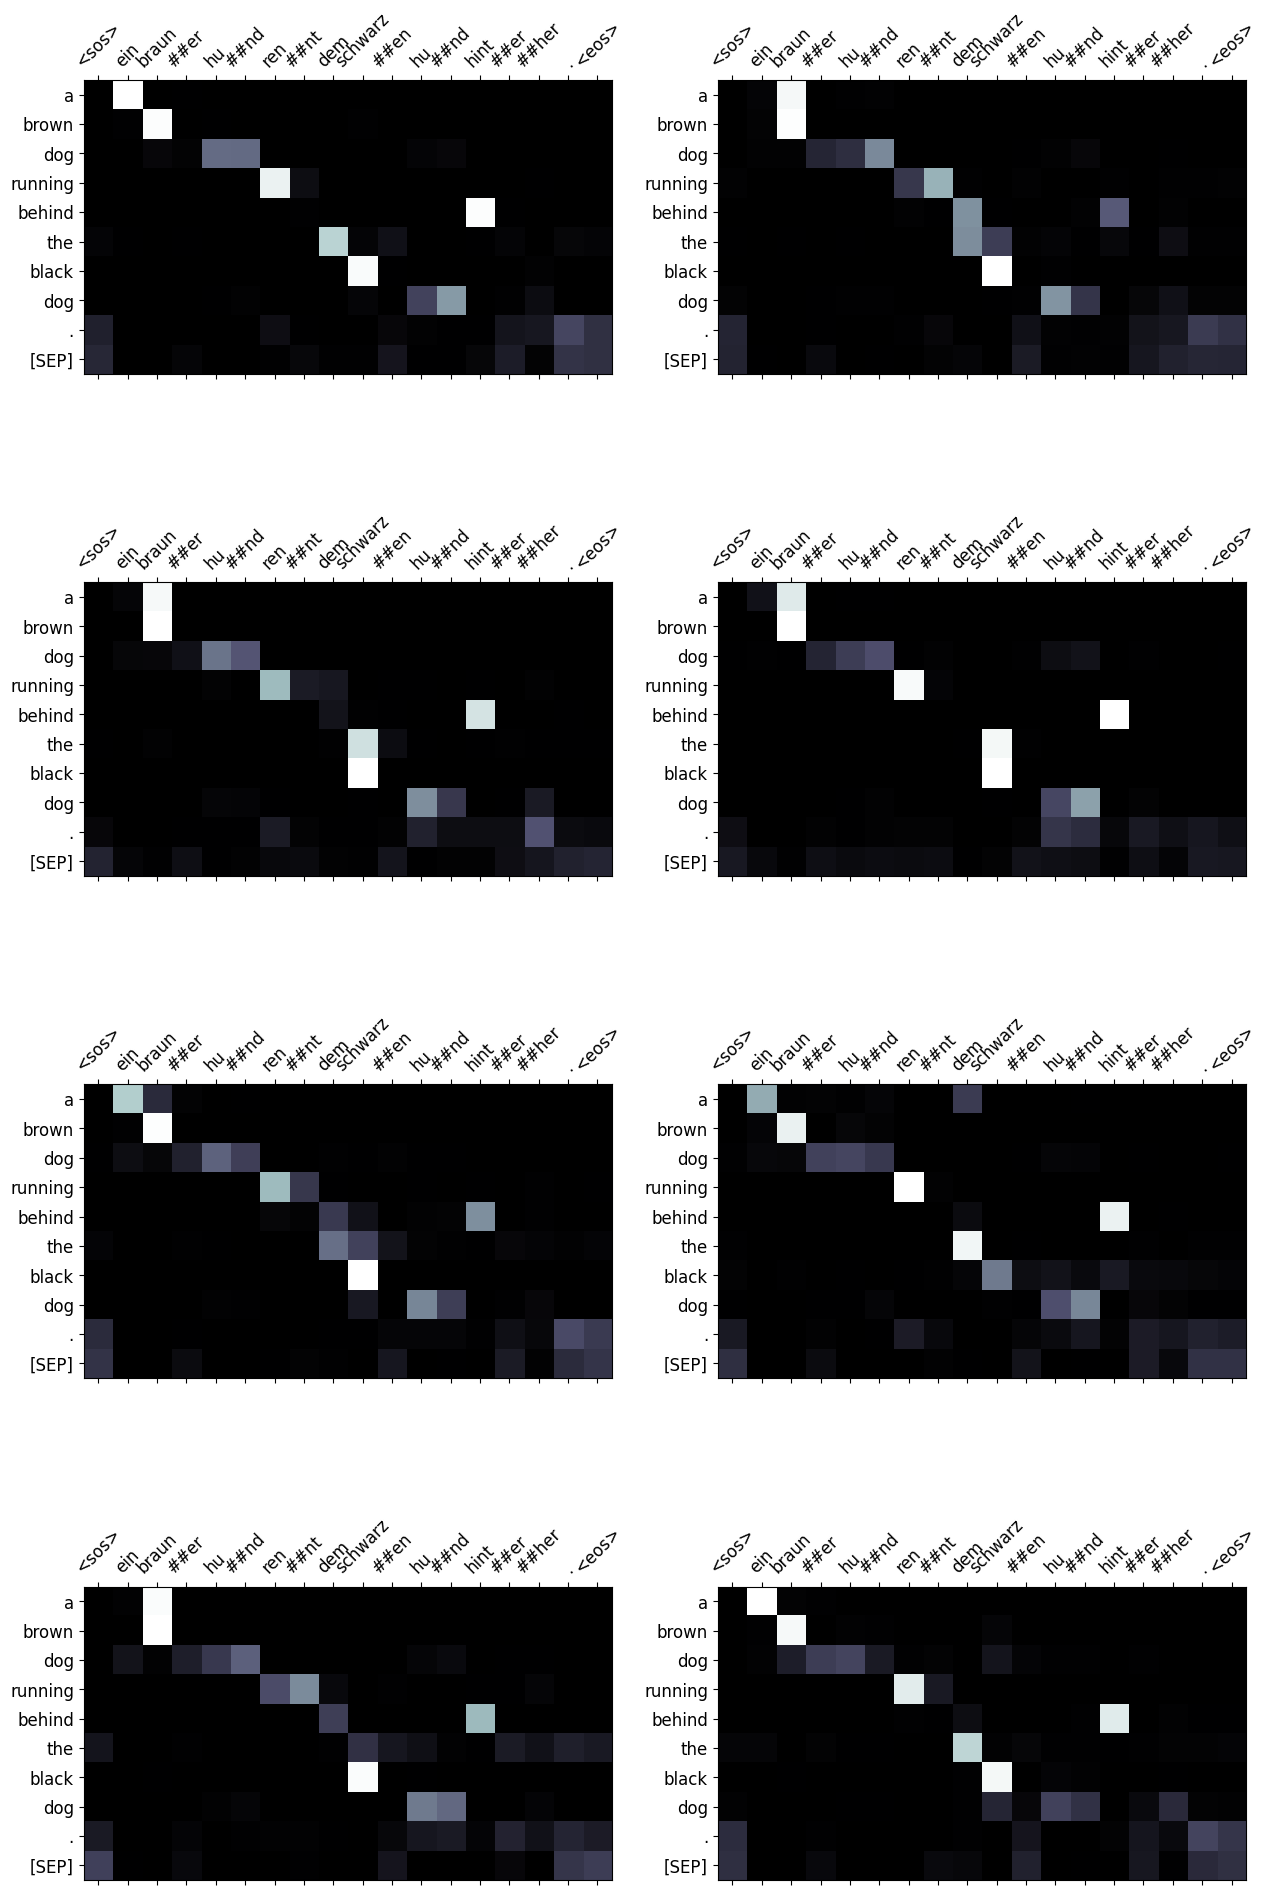

In [87]:
display_attention(src, translation, attention)

### BLEU
- Calculate BLEU for test set

In [88]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):

    trgs = []
    pred_trgs = []

    for datum in data:

        src = vars(datum)['src']
        trg = vars(datum)['trg']

        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)

        #cut off <eos> token
        pred_trg = pred_trg[:-1]

        pred_trgs.append(pred_trg)
        trgs.append([trg])

    return bleu_score(pred_trgs, trgs)

In [89]:
bleu_score = calculate_bleu(test_data_b, BSRC, BTRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 34.82
